# Exploring other ways of extracting visual features based on ViT (hugginface, google, pytorch, clip-openai)

In [1]:
import torch 
import pandas as pd
import os.path as osp
from PIL import Image
from tqdm.notebook import tqdm_notebook as tqdm
from changeit3d.in_out.basics import splitall, pickle_data
from changeit3d.utils.feature_extraction import ImageClassificationDataset

In [2]:
## Download ShapeTalk data first, point then to the underlying directories.

top_img_dir = '../../data/shapetalk/images/full_size'
all_model_uids = '../../data/shapetalk/language/misc/all_model_uids_used.csv'
top_out_dir = '../../data/pretrained/shape_latents'
img_ending = '.png'
gpu_id = 0

In [3]:
## Load filenames of underlying images of all models.
df = pd.read_csv(all_model_uids)
print(len(df))
img_files = top_img_dir + '/' + df.model_uid + img_ending
df = df.assign(img_files=img_files)
assert all(df.img_files.apply(osp.exists)), 'all files exist'

36391


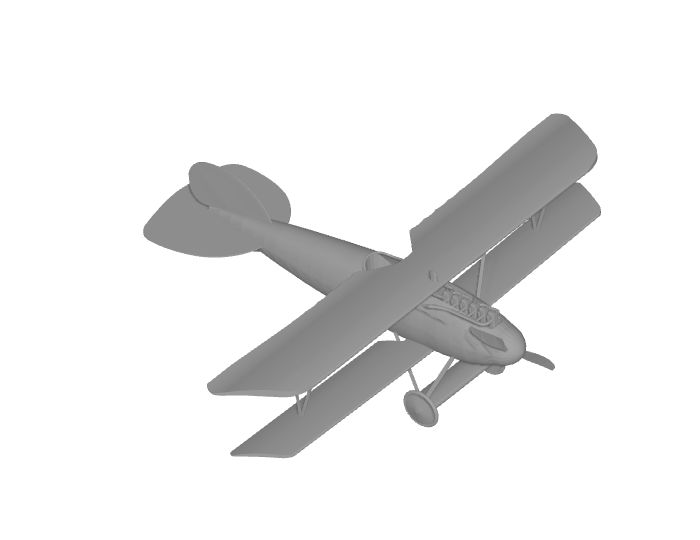

In [4]:
image = Image.open(img_files[0]).convert('RGB')
image

In [5]:
device = torch.device("cuda:" + str(gpu_id))
batch_size = 100
n_workers = 10

## Using ViT from **hugginface**

In [ ]:
from transformers import AutoImageProcessor, ViTModel # you need to install separately this (optional) library

model_name = 'google/vit-base-patch16-224-in21k'
method_name = model_name.replace('/', '_')
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = ViTModel.from_pretrained(model_name).eval().to(device)

In [ ]:
dataset = ImageClassificationDataset(image_files=df.img_files, img_transform=lambda x: image_processor(x, return_tensors="pt"))
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

In [ ]:
feats = []
with torch.no_grad():
    for batch in loader:
        input_img = torch.squeeze(batch['image']['pixel_values']).to(device)   ## there is a mess here and I need to squeeze
        batch['image']['pixel_values'] = input_img                
        outputs = model(**batch['image'])
        last_hidden_states = outputs.pooler_output.cpu()
        feats.append(last_hidden_states)

feats = torch.cat(feats).numpy()

## Using ViT from **raw pytorch**


In [ ]:
from torchvision.models import vit_l_16, ViT_L_16_Weights

preprocess = ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()
model = vit_l_16(weights="IMAGENET1K_SWAG_E2E_V1").eval().to(device)
method_name = "vit_l_16_IMAGENET1K_SWAG_E2E_V1"

In [ ]:
# compare this with model.forward??
def forward_up_to_encoder(self, x: torch.Tensor):
    # Reshape and permute the input tensor
    x = self._process_input(x)
    n = x.shape[0]

    # Expand the class token to the full batch
    batch_class_token = self.class_token.expand(n, -1, -1)
    x = torch.cat([batch_class_token, x], dim=1)

    x = self.encoder(x)

    # Classifier "token" as used by standard language architectures
    x = x[:, 0]
    return x

In [ ]:
dataset = ImageClassificationDataset(image_files=df.img_files, img_transform=preprocess)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

In [ ]:
feats = []

with torch.no_grad():
    for batch in tqdm(loader):
        input_img = batch['image'].to(device)        
        outputs = forward_up_to_encoder(model, input_img).cpu()
        feats.append(outputs)
        
feats = torch.cat(feats).numpy()

## Using **CLIP**

In [11]:
from transformers import CLIPModel, CLIPProcessor

model_name = "openai/clip-vit-large-patch14"                       # standard-large model from OpenAI (CLIP)
# model_name = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"             # very-large model from OpenClip

method_name = model_name.replace('/', '_')

model = CLIPModel.from_pretrained(model_name).to(device).eval()
processor = CLIPProcessor.from_pretrained(model_name)

In [7]:
dataset = ImageClassificationDataset(image_files=df.img_files, img_transform=lambda x : processor(images=x, return_tensors="pt")['pixel_values'][0])
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

In [8]:
feats = []
with torch.no_grad():
    for batch in tqdm(loader):
        input_img = batch['image'].to(device)                
        outputs = model.get_image_features(input_img).cpu()
        feats.append(outputs)        
feats = torch.cat(feats)
feats /= feats.norm(dim=-1, keepdim=True)
feats = feats.numpy()

  0%|          | 0/364 [00:00<?, ?it/s]

In [9]:
# Pass them to a dictionary
shape_to_latent = dict()
cnt = 0
for filename, feat in zip(img_files, feats):
    shape_uid = osp.join(*splitall(filename)[-3:])[:-len(img_ending)]
    shape_to_latent[shape_uid] = feat
    assert df.model_uid.iloc[cnt] == shape_uid
    cnt += 1
assert len(shape_to_latent) == len(df)

In [10]:
# save them 
pickle_data(osp.join(top_out_dir, f'{method_name}_latent_codes.pkl'), shape_to_latent)